In [10]:
from sentence_transformers import SentenceTransformer
import lancedb
from tqdm.notebook import tqdm
import torch
from collections import defaultdict
import re
import pandas as pd
from pathlib import Path
import json
from datetime import datetime
from dotenv import load_dotenv

from openai import OpenAI
from google import genai
from google.genai import types
from sklearn.metrics.pairwise import cosine_similarity
import os
import time
load_dotenv('env_var')

import wikipediaapi
import wikipedia
from burr.core import action, State, ApplicationBuilder, ApplicationContext, Action
from burr.core.parallelism import MapStates, RunnableGraph

from working_folder.workflows.topic_trend_research.prompts.base_prompts import trend_report_prompt, follow_up_prompt, follow_up_query_prompt, \
                                                                                executive_summary_prompt

wiki_wiki = wikipediaapi.Wikipedia(user_agent='Wonky', language='en')

In [2]:
%load_ext burr.integrations.notebook
%burr_ui

In [3]:
# index = lancedb.connect('../wonky_data/indexes/')
# table = index.open_table('sections_hybrid')
# encoder = SentenceTransformer('nomic-ai/nomic-embed-text-v1.5', device='mps', trust_remote_code=True)

In [4]:
base_folder = Path('../wonky_data/')
index_folder = base_folder.joinpath('indexes')

# db = lancedb.connect(index_folder)
# report_tbl = db.open_table("reports")
# section_tbl = db.open_table("reports_section")

In [11]:
client = OpenAI(base_url="http://localhost:1234/v1", api_key="lm-studio")
def call_llm(query, temperature=0.3, seed=42, model="gemma-3-4b-it@Q8_0"):
    completion = client.chat.completions.create(
        model=model,
        messages=[
            {"role": "user", "content": query}
        ],
        temperature=temperature,
        seed=seed,
    )
    return completion.choices[0].message.content

model = "gemini-2.0-flash"
total_tokens = list()

def call_llm_flash(query, temperature=0.1, seed=42, max_tokens=7500 ):
    client = genai.Client(api_key=os.environ['GEMINI_API_KEY'])
    response = client.models.generate_content(
        model=model,
        contents=[query],
        config=types.GenerateContentConfig(
            max_output_tokens=max_tokens,
            temperature=temperature,
            seed=seed
        )
    )
    total_tokens.append({'prompt_tokens':response.usage_metadata.prompt_token_count,
                         'completion_tokens':response.usage_metadata.candidates_token_count,
                         'total_tokens':response.usage_metadata.total_token_count,
                         'timestamp':datetime.now().strftime("%Y_%m_%d_%H_%M_%S")})

    return response.text

In [12]:
from copy import deepcopy
class ParseWikipediaSections():
    def __init__(self):
        self.parsed_sections = list()
        self.current_hierarchy = {'level_0':'', 'level_1':'', 'level_2':'', 'level_3':'', 'level_4':''}

    def _recursive_extract(self, sections, level=0):
        for s in sections:
            # print("%s: %s - %s" % ("*" * (level + 1), s.title, s.text[0:40]))
            hierarchy_string = list()
            for i in range(0,5):
                if i == level:
                    self.current_hierarchy[f"level_{i}"] = s.title
                elif i > level:
                    self.current_hierarchy[f"level_{i}"] = ''

            for i in range(0,5):
                _hierarchy_header = self.current_hierarchy[f"level_{i}"]
                if _hierarchy_header != "":
                    hierarchy_string.append(_hierarchy_header)
            hierarchy_string = '|'.join(hierarchy_string)

            self.parsed_sections.append({"level": level,
                                         "title": s.title,
                                         "text": s.text,
                                         "hierarchy": deepcopy(self.current_hierarchy),
                                         "hierarchy_string": hierarchy_string})

            self._recursive_extract(s.sections, level + 1)

    def parse_wikipedia_sections(self, sections):
        self._recursive_extract(sections, level=0)
        return self.parsed_sections

def get_wikipedia_data(page_name):
    wikipedia_page = wiki_wiki.page(page_name)
    wikipedia_parser = ParseWikipediaSections()
    parsed_sections = wikipedia_parser.parse_wikipedia_sections(wikipedia_page.sections)
    wikipedia_data = {'title': wikipedia_page.title,
                      'url': wikipedia_page.fullurl,
                      'sections': parsed_sections}
    return wikipedia_data

def search_wikipedia_page(query, num_results=10):
    wiki_wiki = wikipediaapi.Wikipedia(user_agent='Wonky', language='en')
    search_results = wikipedia.search(query, results=num_results, suggestion=False)
    print(search_results)
    wikipedia_page_results = list()
    for search_result in search_results:
        wikipedia_page = wiki_wiki.page(search_result)
        wikipedia_parser = ParseWikipediaSections()
        parsed_sections = wikipedia_parser.parse_wikipedia_sections(wikipedia_page.sections)
        try:
            wikipedia_data = {'title': wikipedia_page.title,
                              'url': wikipedia_page.fullurl,
                              'sections': parsed_sections,
                              'full_text': wikipedia_page.text}
        except Exception as e:
            continue
        wikipedia_page_results.append(wikipedia_data)
        time.sleep(1)
    return wikipedia_page_results

def format_sections_w_citations(wiki_document, base_citation):
    first_section = wiki_document[0]
    current_level_1_idx = 1
    current_level_2_idx = 1
    current_level_1_name = first_section['hierarchy']['level_0']
    current_level_2_name = first_section['hierarchy']['level_1']
    formatted_sections = list()
    first_section['citation'] = f"{base_citation}({current_level_1_idx})({current_level_2_idx})"
    formatted_sections.append(first_section)
    if len(wiki_document) > 1:
        for section in wiki_document[1:]:
            # if current_level_1_name == '':
            #     current_level_1_name = section['hierarchy']['level_0']
            # if current_level_2_name == '':
            #     current_level_2_name = section['hierarchy']['level_1']
            #     current_level_2_idx = 1

            if current_level_1_name != section['hierarchy']['level_0']:
                current_level_1_name = section['hierarchy']['level_0']
                current_level_2_name = section['hierarchy']['level_1']
                current_level_1_idx += 1
                current_level_2_idx = 1
                print(current_level_1_name)
            elif (current_level_1_name == section['hierarchy']['level_0']) and (current_level_2_name != section['hierarchy']['level_1']):
                current_level_2_name = section['hierarchy']['level_1']
                current_level_2_idx += 1
            else:
                current_level_2_idx += 1

            section['citation'] = f"{base_citation}({current_level_1_idx})({current_level_2_idx})"
            print(section['citation'])
            formatted_sections.append(section)
            # current_level_1_idx += 1
            # current_level_2_idx = 1
    return formatted_sections

In [13]:
report_folder = Path('wonky_data/data/research_data')
report_file_name = "rural broadband in america_20250416150226.json"
research = [report_folder.joinpath(report_file_name)]
# research_project = 'south_america_research_topics'
# report_folder = report_folder.joinpath(research_project)
# research = list(report_folder.glob('*.json'))

context_folder = Path('wonky_data/data/context_research')
context_file = [context_folder.joinpath(report_file_name)]
research, context_file

([PosixPath('wonky_data/data/research_data/rural broadband in america_20250416150226.json')],
 [PosixPath('wonky_data/data/context_research/rural broadband in america_20250416150226.json')])

In [14]:
with open(research[0],'r') as f:
    research_data = json.load(f)

with open(context_file[0],'r') as f:
    context_data = json.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'wonky_data/data/research_data/rural broadband in america_20250416150226.json'

### Burr Outline

1. Load the data based on a source file
2. Create the trend analysis report
3. Create the follow up document for additional context
4. Vectorize the wikipedia search results and index them
5. Search for the relevant wikipedia articles
6. Format the returned wikipedia sections
7. Extract new information from wikipedia
8. Create new wikipedia trend report
9. Merge wikipedia trend reports
10. Create an executive summary

In [15]:
@action(reads=[], writes=["report_data", "file_name", "file_path"])
def load_report_from_file(state: State, file_path: Path) -> State:
    with open(file_path,'r') as f:
        report_data = json.load(f)

    return state.update(report_data=report_data,
                        file_path=str(file_path),
                        file_name=str(file_path.name))

@action(reads=["report_data"], writes=["trend_report"])
def create_trend_analysis(state: State, topic: str, focus:str) -> State:
    formatted_prompt = trend_report_prompt.format(topic=topic, focus=focus, report_data=state['report_data'])
    trend_report = call_llm(formatted_prompt)

    return state.update(trend_report=trend_report)

@action(reads=["trend_report"], writes=["follow_up_report"])
def create_search_follow_up_document(state: State, topic: str, focus: str) -> State:
    formatted_prompt = follow_up_prompt.format(topic=topic, focus=focus, trend_report=state['trend_report'])
    follow_up_report = call_llm(formatted_prompt)
    return state.update(follow_up_report=follow_up_report)

@action(reads=["follow_up_report"], writes=["follow_up_sources"])
def search_wikipedia(state: State) -> State:
    follow_ups = dict()
    for section, follow_ups in state['follow_up_report'].items():
        formatted_follow_up_prompt = follow_up_query_prompt.format(topic=section, focus=section, trend_report=state['trend_report'],
                                                             follow_up=follow_ups)
        query = call_llm(formatted_follow_up_prompt)
        results = search_wikipedia_page(query, num_results=10)

        follow_ups[section] = results

    return state.update(follow_up_sources=follow_ups)

@action(reads=["follow_up_sources"], writes=["temp_index"])
def vectorize_and_index_wikipedia(state: State, temp_index_path: Path) -> State:
    # magic here to create temporary database

    # create the full document index

    # create the section level index

    return state.update(temp_index = temp_index_path)

@action(reads=["temp_index"], writes=["context_sections"])
def search_relevant_wiki_sections(state: State) -> State:
    context_sections = list()
    # magic to search the index

    # Add citations to the information

    return state.update(context_sections=context_sections)

@action(reads=["context_sections"], writes=["wikipedia_trend_report"])
def create_wikipedia_trend_report(state: State, topic: str, focus: str) -> State:
    formatted_trend_prompt = trend_report_prompt.format(topic=topic, focus=focus,
                                                        context_data=state['context_sections'])
    wikipedia_trend_report = call_llm(formatted_trend_prompt)

    return state.update(wikipedia_trend_report=wikipedia_trend_report)

@action(reads=["wikipedia_trend_report","trend_report"], writes=["merged_trend_report"])
def merge_trend_reports(state: State, file_path: Path) -> State:
    formatted_prompt = merge_trend_reports.format(trend_report = state['trend_report'],
                                                  context_report = state['wikipedia_trend_report'])
    merged_trend_report = call_llm(formatted_prompt)
    return state.update(merged_trend_report=merged_trend_report)

@action(reads=["wikipedia_trend_report","report_data"], writes=["executive_summary"])
def create_executive_summary(state: State, topic: str, focus: str) -> State:
    formatted_executive_prompt = executive_summary_prompt.format(topic=topic, focus=focus,
                                                         report=state['report_data']['report'],
                                                         trend_report=state['merged_trend_report'])

    executive_summary = call_llm(formatted_executive_prompt)
    return state.update(executive_summary=executive_summary)

In [19]:
app = (
    ApplicationBuilder()
    .with_actions(
        load_report_from_file,
        create_trend_analysis,
        create_search_follow_up_document,
        search_wikipedia,
        vectorize_and_index_wikipedia,
        search_relevant_wiki_sections,
        create_wikipedia_trend_report,
        merge_trend_reports,
        create_executive_summary
    )
    .with_transitions(
        ("load_report_from_file", "create_trend_analysis"),
        ("create_trend_analysis", "create_search_follow_up_document"),
        ("create_search_follow_up_document", "search_wikipedia"),
        ("search_wikipedia", "vectorize_and_index_wikipedia"),
        ("vectorize_and_index_wikipedia", "search_relevant_wiki_sections"),
        ("search_relevant_wiki_sections","create_wikipedia_trend_report"),
        ("create_wikipedia_trend_report", "merge_trend_reports"),
        ("merge_trend_reports", "create_executive_summary"))
    .with_entrypoint("load_report_from_file")
    .with_tracker(
        "local",
        project=f"research_batch-single_run",
    )
    .build()
)

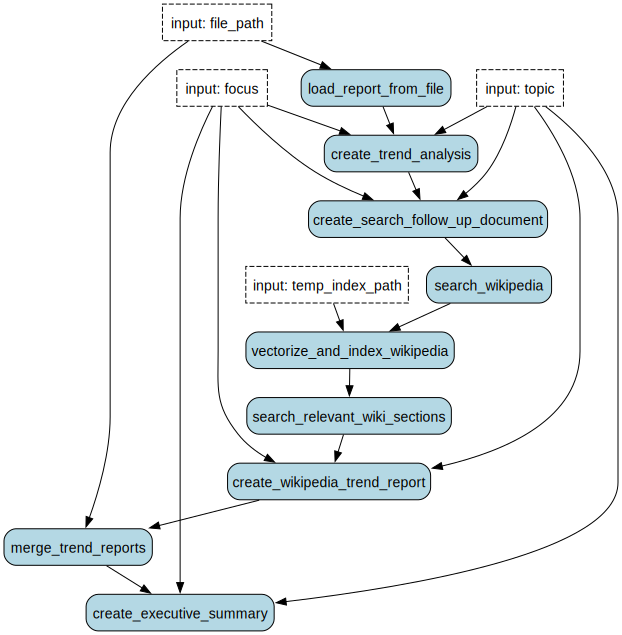

In [21]:
app.visualize("./graph", format="png")

In [12]:
formatted_trend_analysis_prompt = brief_analysis_prompt.format(topic=research_data['topic'],
                                                               focus=research_data['focus'],
                                                               report=research_data['report'],
                                                               sources=research_data['formatted_report_grounding'])

In [15]:
trend_report = call_llm_flash(formatted_trend_analysis_prompt)

In [18]:
formatted_follow_up_prompt = follow_up_context_prompt.format(topic=research_data['topic'],
                                                             focus=research_data['focus'],
                                                             report=research_data['report'],
                                                             trend_analysis=trend_report)

In [19]:
follow_up_context = call_llm_flash(formatted_follow_up_prompt)

In [21]:
different_followups = re.findall(r'(##[\s\S]+?)(?=##|$)', follow_up_context, flags=re.DOTALL)
follow_up_groups = dict()
for group in different_followups:
    group_name = group.split('\n')[0]
    followups = re.findall(r'[\*-]\s*(.+?)(?:\n|$)', group, flags=re.DOTALL)
    followups = [x.strip() for x in followups]
    follow_up_groups[group_name.strip()] = followups

In [26]:
vectorized_sections = list()
for context_search in tqdm(context_data):
    context_topic = context_search['topic']
    context_focus = context_search['focus']
    context_query = context_search['query']
    for wiki_page in tqdm(context_search['context']):
        wiki_page_title = wiki_page['title']
        for section_idx, section in tqdm(enumerate(wiki_page['sections'])):
            section_copy = deepcopy(section)
            section_copy['vector'] = encoder.encode(f"{wiki_page_title}\n{section_copy['title']}\n{' '.join(section_copy['hierarchy_string'].split('|'))}\n{section_copy['text']}").tolist()

            section_copy['topic'] = context_topic
            section_copy['focus'] = context_focus
            section_copy['query'] = context_query
            section_copy['page_title'] = wiki_page_title
            section_copy['section_idx'] = section_idx

            vectorized_sections.append(section_copy)
            torch.mps.empty_cache()


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [27]:
context_index_data = pd.DataFrame(vectorized_sections)

In [28]:
context_index_data

,level,title,text,hierarchy,hierarchy_string,vector,topic,focus,query,page_title,section_idx
0,0,Background,In the modern sense of offering service to all...,"{'level_0': 'Background', 'level_1': '', 'leve...",Background,"[-0.33777323365211487, 1.4030901193618774, -3....",Rural Broadband in America,"Historical, current, and future challenges for...","""Universal Service Fund"" ""rural broadband""",Universal Service Fund,0
1,1,Implicit subsidies for local service (1970-1982),In the 1960s the telecommunication monopolies ...,"{'level_0': 'Background', 'level_1': 'Implicit...",Background|Implicit subsidies for local servic...,"[0.506664514541626, 1.5709733963012695, -3.488...",Rural Broadband in America,"Historical, current, and future challenges for...","""Universal Service Fund"" ""rural broadband""",Universal Service Fund,1
2,1,Breakup of the Bell system (1982-1996),There was a push for deregulating the telecomm...,"{'level_0': 'Background', 'level_1': 'Breakup ...",Background|Breakup of the Bell system (1982-1996),"[0.26263627409935, 1.5298961400985718, -2.9283...",Rural Broadband in America,"Historical, current, and future challenges for...","""Universal Service Fund"" ""rural broadband""",Universal Service Fund,2
3,0,History,,"{'level_0': 'History', 'level_1': '', 'level_2...",History,"[-0.06453355401754379, 1.4757651090621948, -4....",Rural Broadband in America,"Historical, current, and future challenges for...","""Universal Service Fund"" ""rural broadband""",Universal Service Fund,3
4,1,Telecommunications Act of 1996,The Universal Service Fund was first codified ...,"{'level_0': 'History', 'level_1': 'Telecommuni...",History|Telecommunications Act of 1996,"[-0.4172077178955078, 1.0427643060684204, -3.6...",Rural Broadband in America,"Historical, current, and future challenges for...","""Universal Service Fund"" ""rural broadband""",Universal Service Fund,4
...,...,...,...,...,...,...,...,...,...,...,...
380,0,Overview,,"{'level_0': 'Overview', 'level_1': '', 'level_...",Overview,"[-0.5523691773414612, 1.02926766872406, -3.697...",Rural Broadband in America,"Historical, current, and future challenges for...","""Broadband Technology Opportunities Program"" ""...",ConnectEd Initiative,3
381,1,Upgrading Connectivity,The ConnectEd initiative aims to increase inte...,"{'level_0': 'Overview', 'level_1': 'Upgrading ...",Overview|Upgrading Connectivity,"[-0.5633025169372559, 1.5199469327926636, -3.3...",Rural Broadband in America,"Historical, current, and future challenges for...","""Broadband Technology Opportunities Program"" ""...",ConnectEd Initiative,4
382,1,Training Teachers,"In order to improve student outcomes, the Conn...","{'level_0': 'Overview', 'level_1': 'Training T...",Overview|Training Teachers,"[-0.8425822257995605, 1.0219800472259521, -3.1...",Rural Broadband in America,"Historical, current, and future challenges for...","""Broadband Technology Opportunities Program"" ""...",ConnectEd Initiative,5
383,1,Encouraging Private Sector Innovation,ConnectEd calls on the private sector to provi...,"{'level_0': 'Overview', 'level_1': 'Encouragin...",Overview|Encouraging Private Sector Innovation,"[-0.8617445826530457, 2.194448947906494, -3.43...",Rural Broadband in America,"Historical, current, and future challenges for...","""Broadband Technology Opportunities Program"" ""...",ConnectEd Initiative,6


In [351]:
temp_research_table = index.create_table('temp_research', data=context_index_data, mode='overwrite')

In [352]:
temp_research_table.create_fts_index(['text','title'], replace=True)

In [354]:
context_results = dict()
all_context_documents = list()
for group, followup_group in follow_up_groups.items():
    all_search_results = list()
    for follow_up in followup_group:
        follow_up_vector = encoder.encode(follow_up).tolist()
        torch.mps.empty_cache()

        follow_up_search_vector = temp_research_table.search(follow_up_vector).distance_type('cosine').limit(20).to_pandas()
        follow_up_search_fts = temp_research_table.search(follow_up).limit(20).to_pandas()
        follow_up_search = pd.concat([follow_up_search_vector, follow_up_search_fts])
        all_search_results.append(follow_up_search)
    all_search_results = pd.concat(all_search_results)
    all_search_results = all_search_results.drop_duplicates(subset=['page_title','section_idx'], keep='first')
    all_search_results['section_start'] = all_search_results.groupby(['page_title','hierarchy_string'])['section_idx'].transform('min')
    all_search_results = all_search_results.sort_values(by=['page_title','section_start','section_idx'])
    context_results[group] = all_search_results
    all_context_documents.append(all_search_results)


all_context_documents = pd.concat(all_context_documents)
all_context_documents = all_context_documents.drop_duplicates(subset=['page_title','section_idx'], keep='first')
all_context_documents['section_start'] = all_context_documents.groupby(['page_title','hierarchy_string'])['section_idx'].transform('min')
all_context_documents = all_context_documents.sort_values(by=['page_title','section_start','section_idx'])

In [355]:
all_context_documents = all_context_documents.drop_duplicates(subset=['page_title','text'])
all_context_documents = all_context_documents[all_context_documents['text'].str.strip() != '']

In [357]:
formatted_context_sections = list()
all_context_grounding = list()
for _page_title, _group in all_context_documents.groupby(['page_title']):
    # group_text = '\n\n'.join(_group['text'])
    formatted_wiki_text = format_sections_w_citations(_group.to_dict(orient='records'), _page_title[0])
    group_text = ""
    for section in formatted_wiki_text:
        formatted_context_sections.append(deepcopy(section))
        _formatted_section = f"\n- {section['text']} ({section['citation']})"
        group_text += _formatted_section
    group_text = group_text.strip()
    all_context_grounding.append(f"#### Title: {_page_title[0]}\n\n{group_text}")

context_grounding = '\n\n'.join(all_context_grounding).strip()
print(len(context_grounding.split(' ')))
# all_context_grounding.append(context_grounding)

Products and technology
Alvarion(2)(1)
Commercial development
Alvarion(3)(1)
Broadband universal service(1)(2)
Broadband universal service(1)(3)
Implementation
Broadband universal service(2)(1)
Broadband universal service(2)(2)
Broadband universal service(2)(3)
Broadband universal service(2)(4)
Broadband universal service(2)(5)
Broadband universal service(2)(6)
See also
Broadband universal service(3)(1)
External links
Broadband universal service(4)(1)
Timeline
ConnectEd Initiative(2)(1)
Funding
ConnectEd Initiative(3)(1)
Overview
ConnectEd Initiative(4)(1)
ConnectEd Initiative(4)(2)
ConnectEd Initiative(4)(3)
Implications
ConnectEd Initiative(5)(1)
Digital divide in the United States(1)(2)
Digital divide in the United States(1)(3)
Digital divide in the United States(1)(4)
Digital divide in the United States(1)(5)
Digital divide in the United States(1)(6)
Digital divide in the United States(1)(7)
Digital divide in the United States(1)(8)
Means of connectivity
Digital divide in the Unite

In [361]:
areas_of_interest = list()
for follow_up_type, follow_up_points in follow_up_groups.items():
    points_to_follow_up = ['- ' + x for x in follow_up_points]
    points_to_follow_up = '\n'.join(points_to_follow_up)
    areas_of_interest.append(points_to_follow_up)

In [363]:
formatted_prompts = list()
formatted_extraction_prompt = extract_context_information_prompt.format(topic=context_topic,
                                                                            focus=context_focus,
                                                                            areas_of_interest=_area_of_interest,
                                                                            trend_analysis=trend_report,
                                                                            articles=context_grounding)
formatted_prompts.append(formatted_extraction_prompt)

In [365]:
follow_up_extractions = list()
for _follow_up_prompt in tqdm(formatted_prompts):
    extraction = call_llm_flash(_follow_up_prompt, max_tokens=7500)
    follow_up_extractions.append(extraction)

  0%|          | 0/1 [00:00<?, ?it/s]

In [367]:
all_follow_up_extractions = '\n\n----------\n\n'.join(follow_up_extractions)

In [373]:
formatted_trend_interpolation_prompt = trend_interpolation_prompt.format(topic=context_topic,
                                                                         focus=context_focus,
                                                                         trend_analysis=trend_report,
                                                                         notes=all_follow_up_extractions)
len(formatted_extraction_prompt.split(' '))

43559

In [375]:
expanded_trend_report = call_llm_flash(formatted_trend_interpolation_prompt, max_tokens=10000)

In [381]:
merged_trend_formatted_prompt = merged_trend_report_prompt.format(topic=context_topic,
                                                                  focus=context_focus,
                                                                  initial_report=trend_report,
                                                                  additional_report=expanded_trend_report)

In [382]:
merged_trend_report = call_llm_flash(merged_trend_formatted_prompt, max_tokens=10000)

In [384]:
full_research_folder = Path('wonky_data/data/full_research')
full_research_folder = full_research_folder.joinpath(research[0].stem)
full_research_folder.mkdir(parents=True, exist_ok=True)

full_research_documents_folder = full_research_folder.joinpath('documents')
full_research_documents_folder.mkdir(parents=True, exist_ok=True)

full_research_trace_folder = full_research_folder.joinpath('trace')
full_research_trace_folder.mkdir(parents=True, exist_ok=True)

In [385]:
report_file_name

'rural broadband in america_20250416150226.json'

In [386]:
context_grounding_save_out = dict()
for _area_of_interest, _context in context_results.items():
    _cleaned_context = _context.copy()
    _cleaned_context['vector'] = _cleaned_context['vector'].apply(lambda x: x.tolist())
    context_grounding_save_out[_area_of_interest] = _cleaned_context.to_dict(orient='records')

In [389]:
formatted_executive_summary_prompt = executive_summary_prompt.format(topic=research_data['topic'],
                                                                     focus=research_data['focus'],
                                                                     trend_report=merged_trend_report,
                                                                     report=research_data['report'])

In [390]:
executive_summary = call_llm_flash(formatted_executive_summary_prompt, max_tokens=10000)

In [392]:
trace_data = {"trend_report":trend_report,
                     "report":research_data['report'],
                     "follow_up_context":follow_up_context,
                     "expanded_trend_report":expanded_trend_report,
                     "trend_research":context_grounding_save_out,
                     "topic":research_data['topic'],
                     "focus":research_data['focus'],
                     "source_file_name":report_file_name,
                     "executive_summary":executive_summary,
              "followup_extractions":all_follow_up_extractions,
              "merged_trend_report":merged_trend_report}

documents_to_save = {"trend_report":trend_report,
                     "report":research_data['report'],
                     "follow_up_context":follow_up_context,
                     "expanded_trend_report":expanded_trend_report,
                     "source_file_name":report_file_name,
                     "executive_summary":executive_summary,
                     "followup_extractions":all_follow_up_extractions,
                     "merged_trend_report":merged_trend_report}

In [393]:
with open(full_research_trace_folder.joinpath('research_data.json'),'w') as f:
    json.dump(trace_data,f)

In [394]:
for document_type, document in documents_to_save.items():
    with open(full_research_documents_folder.joinpath(document_type+'.md'),'w') as f:
        f.write(document)

In [395]:
print(f"topic: {trace_data['topic']} with a focus on: {trace_data['focus']}")

topic: Rural Broadband in America with a focus on: Historical, current, and future challenges for rural broadband and connectivity in America
